In [1]:
# データをダウンロード
# !curl -O https://raw.githubusercontent.com/jamovi/r-datasets/master/data/Seatbelts.csv
# mv Seatbelts.csv ./input/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import pmdarima as pm

In [3]:
path = "../input/Seatbelts.csv"
df = pd.read_csv(path).drop("Unnamed: 0", axis=1)
print(df.shape)
display(df.head())
print(df.columns)


(192, 8)


,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,107,1687,867,269,9059,0.102972,12,0
1,97,1508,825,265,7685,0.102363,6,0
2,102,1507,806,319,9963,0.102062,12,0
3,87,1385,814,407,10955,0.100873,8,0
4,119,1632,991,454,11823,0.101020,10,0


Index(['DriversKilled', 'drivers', 'front', 'rear', 'kms', 'PetrolPrice',
       'VanKilled', 'law'],
      dtype='object')


- front: 前席における死傷者数
- petrolprice: ガソリンの値段
- law: 前席においてシートベルトを着用することを義務付けた法律の施行の有無

In [4]:
# 1969 ~ 1984年までの毎月のデータ
# 手動で日付を付与
ymd = []
cnt = 0
for y in range(1969, 1985):
    for m in range(1, 13):
        ymd.append(pd.to_datetime(f"{y}-{m}-01"))
        cnt += 1

df["timestamp"] = ymd
df.head()


,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law,timestamp
0,107,1687,867,269,9059,0.102972,12,0,1969-01-01
1,97,1508,825,265,7685,0.102363,6,0,1969-02-01
2,102,1507,806,319,9963,0.102062,12,0,1969-03-01
3,87,1385,814,407,10955,0.100873,8,0,1969-04-01
4,119,1632,991,454,11823,0.101020,10,0,1969-05-01


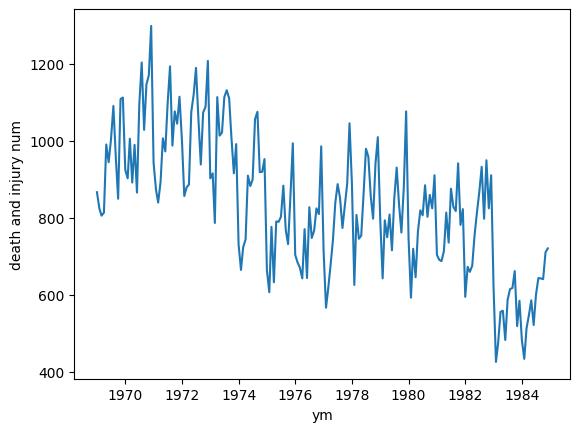

In [5]:
plt.plot(df["timestamp"], df["front"])
plt.xlabel("ym")
plt.ylabel("death and injury num")
plt.show()


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


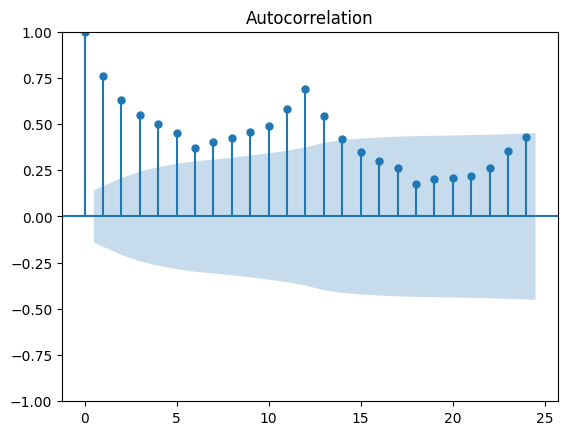

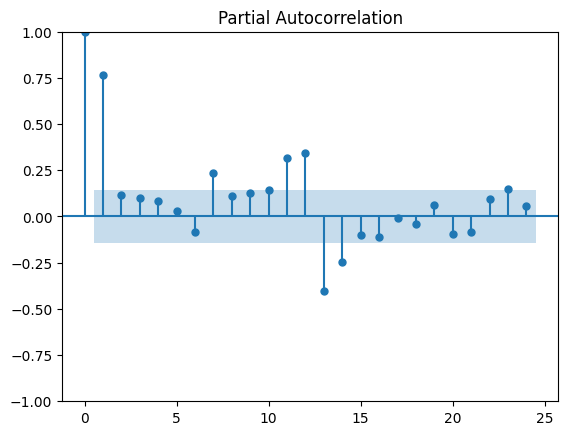

In [6]:
# 自己相関のグラフ
# コレログラム（）
sm.graphics.tsa.plot_acf(df["front"], lags=24)
sm.graphics.tsa.plot_pacf(df["front"], lags=24)
plt.show()


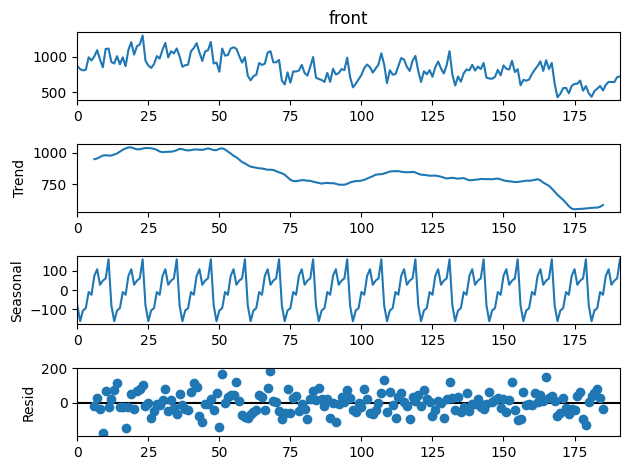

In [7]:
# データをトレンド成分、季節成分に分解
seasonal_decompose_res = sm.tsa.seasonal_decompose(df["front"], period=12)
seasonal_decompose_res.plot()
plt.show()


In [8]:
# 単位根検定 KPSS検定
# 帰無仮説: 単位根なし, 対立仮説: 単位根あり
stats, p_value, lags, crit = sm.tsa.kpss(df["front"])
print(f"stats: {stats}, p_value: {p_value}, lags: {lags}, crit: {crit}")
# 帰無仮説は棄却され、単位根があるとみなせる


stats: 1.550066754386029, p_value: 0.01, lags: 8, crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


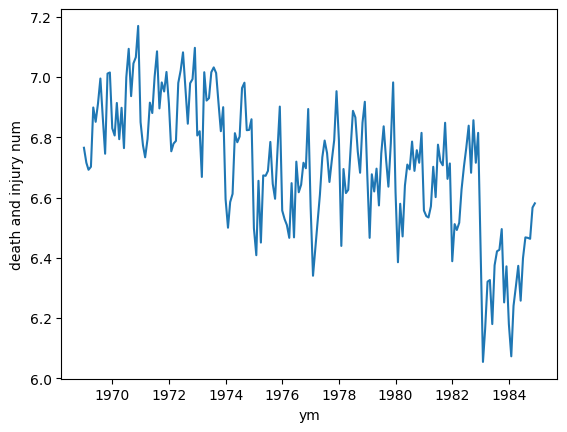

In [9]:
# 個数、人数は対数変換してからモデル化するとうまい具合にモデル化できることがある
# 今回のデータに対してはぶっちゃけ対数変換しても変わらなく見えるが、テキスト通りに進める
df["log_front"] = np.log(df["front"])
plt.plot(df["timestamp"], df["log_front"])
plt.xlabel("ym")
plt.ylabel("death and injury num")
plt.show()


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


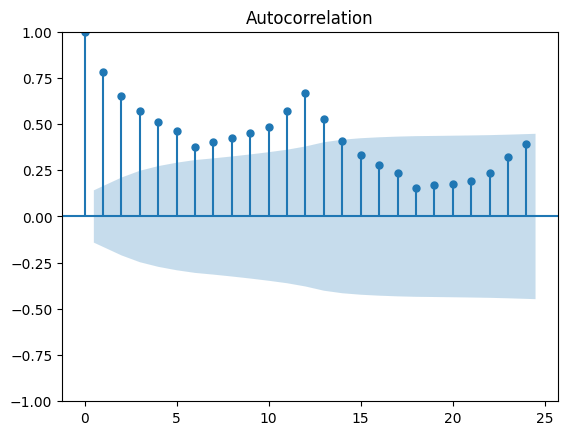

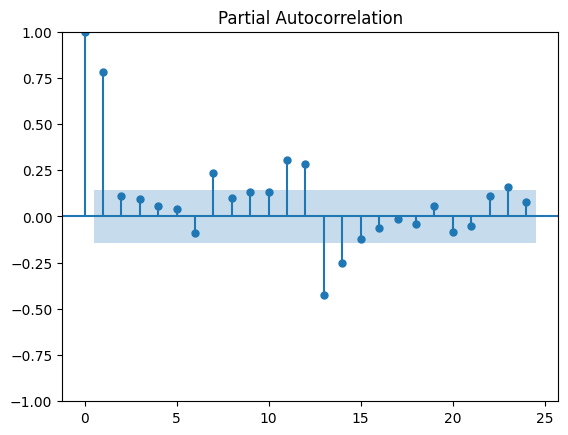

In [10]:
# 自己相関のグラフ
# コレログラム
sm.graphics.tsa.plot_acf(df["log_front"], lags=24)
sm.graphics.tsa.plot_pacf(df["log_front"], lags=24)
plt.show()


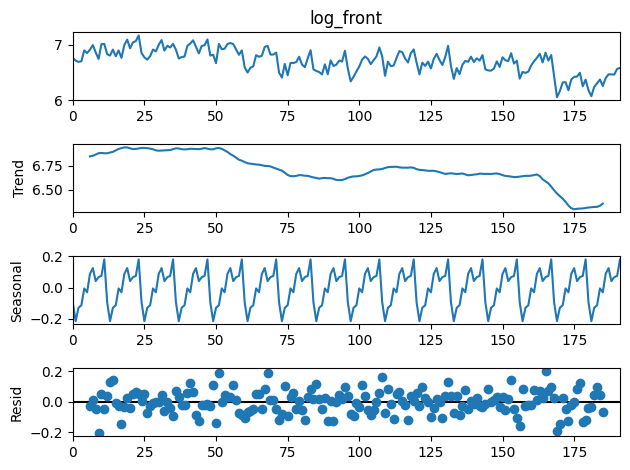

In [11]:
# データをトレンド成分、季節成分に分解
seasonal_decompose_res = sm.tsa.seasonal_decompose(df["log_front"], period=12)
seasonal_decompose_res.plot()
plt.show()


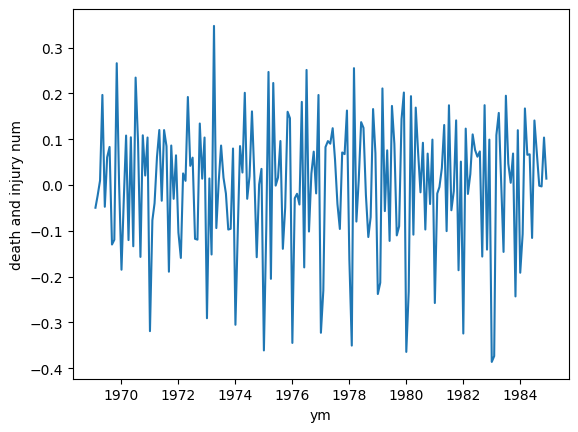

In [12]:
# 差分系列を取り、同様に可視化を行う
df["diff_log_front"] = df["log_front"] - df["log_front"].shift()
plt.plot(df["timestamp"], df["diff_log_front"])
plt.xlabel("ym")
plt.ylabel("death and injury num")
plt.show()

# 長期にわたって平均値が変化していない → 単位根がなくなったっぽい


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


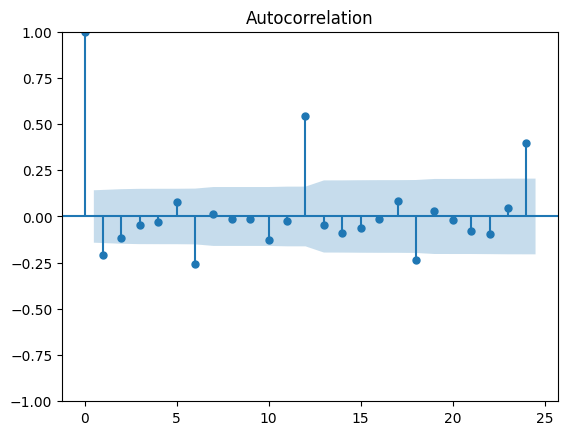

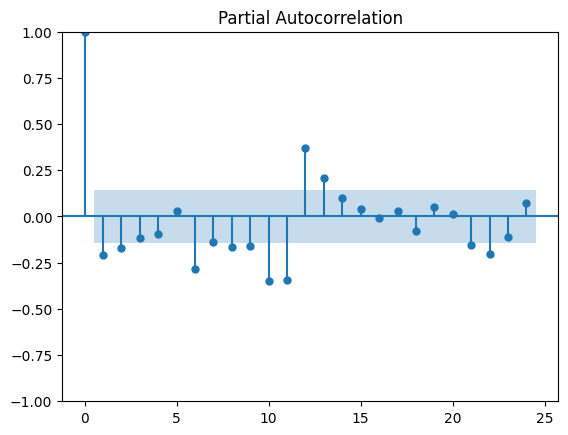

In [13]:
sm.graphics.tsa.plot_acf(df["diff_log_front"].dropna(), lags=24)
sm.graphics.tsa.plot_pacf(df["diff_log_front"].dropna(), lags=24)
plt.show()

# 短期の自己相関が減ったが一部で自己相関がある（1年おき）


In [14]:
# 単位根検定 KPSS検定
# 帰無仮説: 単位根なし, 対立仮説: 単位根あり
stats, p_value, lags, crit = sm.tsa.kpss(df["diff_log_front"].dropna())
print(f"stats: {stats}, p_value: {p_value}, lags: {lags}, crit: {crit}")
# 帰無仮説は棄却されず、単位根があるとみなせる

stats: 0.04703999937354582, p_value: 0.1, lags: 17, crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [27]:

df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month

Jan average front: 768.1875
Feb average front: 686.5
Mar average front: 735.25
Apr average front: 745.875
May average front: 833.3125
Jun average front: 815.0625
jul average front: 905.5
Aug average front: 938.5
Sep average front: 861.3125
Oct average front: 879.875
Nov average front: 893.25
Dec average front: 984.0


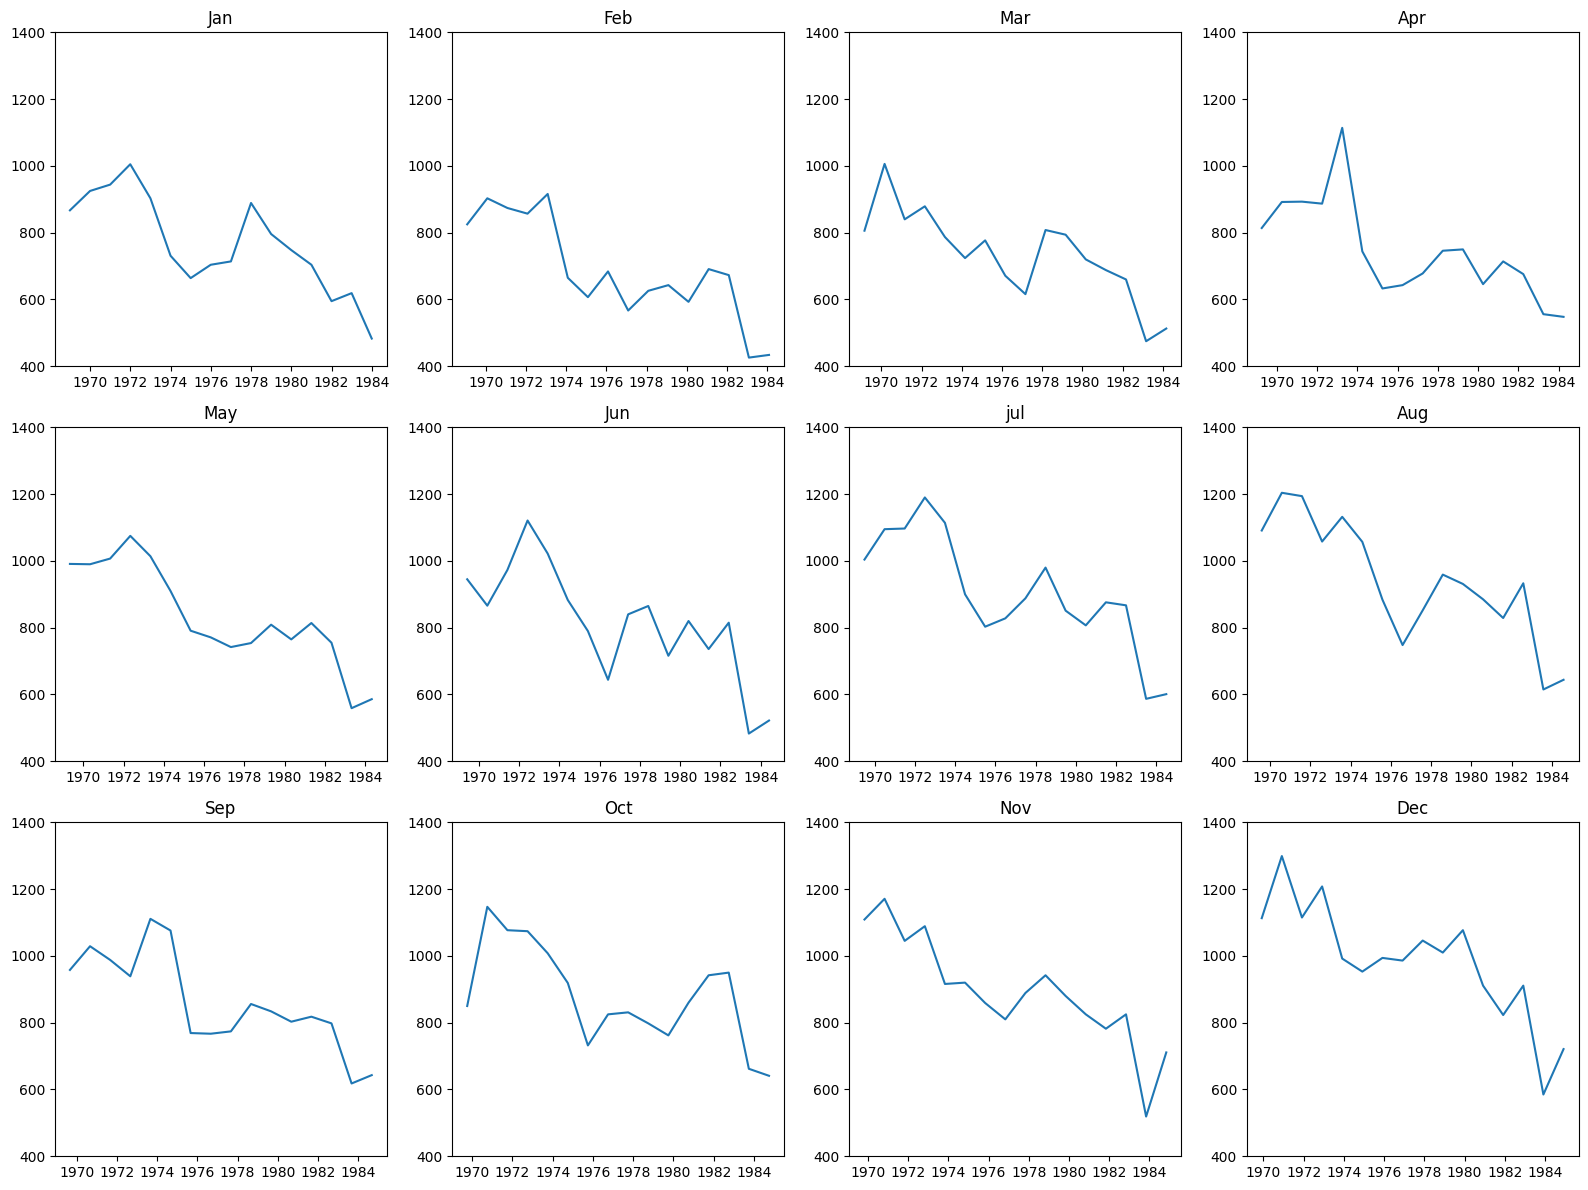

In [38]:

month_name = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
# 月ごとにプロット
for i in range(12):
    row = i // 4
    col = i % 4
    tmp = df.loc[df["month"] == i + 1]
    ax[row][col].plot(tmp["timestamp"], tmp["front"])
    ax[row][col].set_title(month_name[i])
    ax[row][col].set_ylim(400, 1400)
    print(f"{month_name[i]} average front: {tmp['front'].mean()}")


plt.tight_layout()
plt.show()

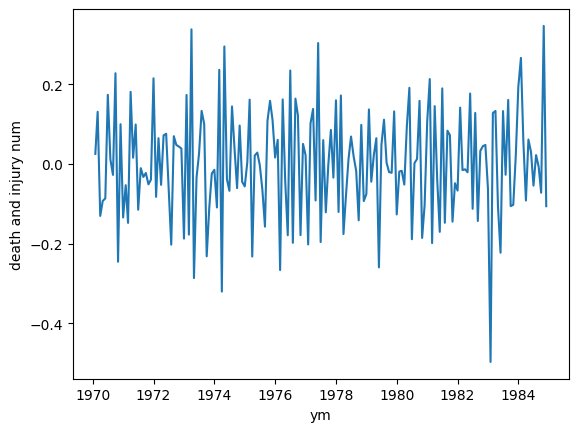

In [15]:
# 季節成分(1年周期)を取ってみる
df["diff_12_diff_log_front"] = df["diff_log_front"] - df["diff_log_front"].shift(12)

plt.plot(df["timestamp"], df["diff_12_diff_log_front"])
plt.xlabel("ym")
plt.ylabel("death and injury num")
plt.show()


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


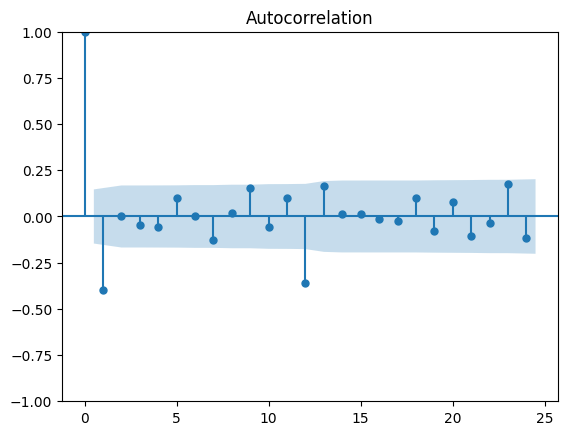

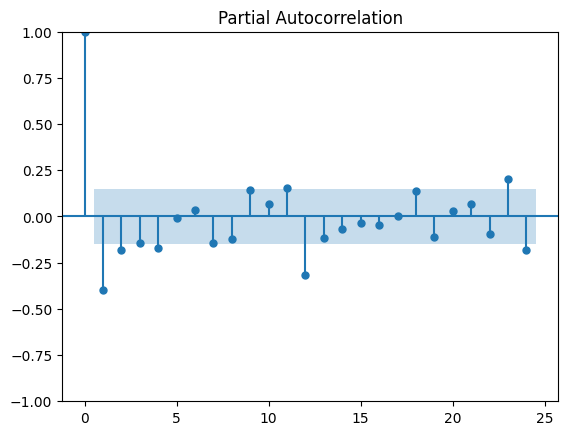

In [16]:
sm.graphics.tsa.plot_acf(df["diff_12_diff_log_front"].dropna(), lags=24)
sm.graphics.tsa.plot_pacf(df["diff_12_diff_log_front"].dropna(), lags=24)
plt.show()

# 自己相関はほとんどなくなった


In [17]:

# 単位根検定 KPSS検定
# 帰無仮説: 単位根なし, 対立仮説: 単位根あり
stats, p_value, lags, crit = sm.tsa.kpss(df["diff_12_diff_log_front"].dropna())
print(f"stats: {stats}, p_value: {p_value}, lags: {lags}, crit: {crit}")
# 帰無仮説は棄却されず、単位根があるとみなせる

stats: 0.13566806027200307, p_value: 0.1, lags: 26, crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Training

In [39]:
test_year = 1984
train = df.loc[df["timestamp"].dt.year != test_year].reset_index(drop=True)
test = df.loc[df["timestamp"].dt.year == test_year].reset_index(drop=True)

model_sarimax = sm.tsa.arima.ARIMA(
    endog=train["log_front"], exog=train.loc[:, ["PetrolPrice", "law"]], order=(1, 1, 1), seasonal_order=(1, 0, 0, 12)
)
res = model_sarimax.fit()
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         log_front   No. Observations:                  180
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                 164.923
Date:                           Sun, 21 May 2023   AIC                           -317.845
Time:                                   14:37:41   BIC                           -298.721
Sample:                                        0   HQIC                          -310.090
                                           - 180                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PetrolPrice    -3.3205      0.891     -3.727      0.000      -5.067      -1.574
law            -0.3712      0.045     -8

/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# pmdarima で ARIMA モデルを自動構築
model_arima_auto = pm.auto_arima(train["log_front"], seasonal=True, m=12, trace=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-273.368, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-174.103, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-259.776, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-240.198, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-176.063, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-234.956, Time=0.18 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-261.909, Time=0.18 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-272.187, Time=0.57 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-275.321, Time=0.40 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-243.474, Time=0.49 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-286.761, Time=0.59 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=-275.007, Time=0.43 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=-271.382, Time=0.57 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=-282.578, Time=0.55 sec
 ARIMA(2,1,3)(2,0,2

In [20]:
model_sarimax2 = sm.tsa.arima.ARIMA(
    endog=train["log_front"], 
    exog=train.loc[:, ["PetrolPrice", "law"]], 
    order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
)
res2 = model_sarimax2.fit()
print(res2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                        log_front   No. Observations:                  180
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 167.680
Date:                          Sun, 21 May 2023   AIC                           -321.359
Time:                                  14:20:46   BIC                           -299.533
Sample:                                       0   HQIC                          -312.500
                                          - 180                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PetrolPrice    -3.3666      1.092     -3.083      0.002      -5.507      -1.226
law            -0.3419      0.047     -7.220    

/home/kouya-takahashi/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- Ljung-Box (リュング・ボックス検定)
    - 帰無仮説: データは無作為である（lag 1 からlag m までのすべてで自己相関が 0）
    - 対立仮説: データは無作為ではない（lag 1 からlag m までの自己相関のうち、少なくとも一つが 0 ではない）
    - 残差が独立であることを確認するために使用する
- ↑の結果では帰無仮説は棄却され、データは無作為ではない

,lb_stat,lb_pvalue
1,0.009614,0.921892
2,0.011603,0.994215
3,0.013343,0.999592
4,0.121987,0.998214
5,0.133239,0.999671
6,0.178845,0.999889
7,0.265527,0.999934
8,0.265721,0.999988
9,0.280409,0.999998
10,0.444731,0.999996


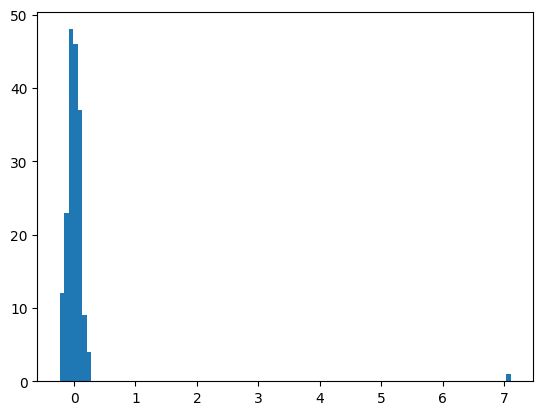

In [40]:
# Ljung-Box検定
# この結果から自己相関がないとはいえず、このモデルはあまりよくなさそう
resid = res.resid
ljung = sm.stats.diagnostic.acorr_ljungbox(resid, lags=12)
display(ljung)

# 残差のヒストグラム
# 外れ値の影響かも
plt.hist(resid, bins=100)
plt.show()

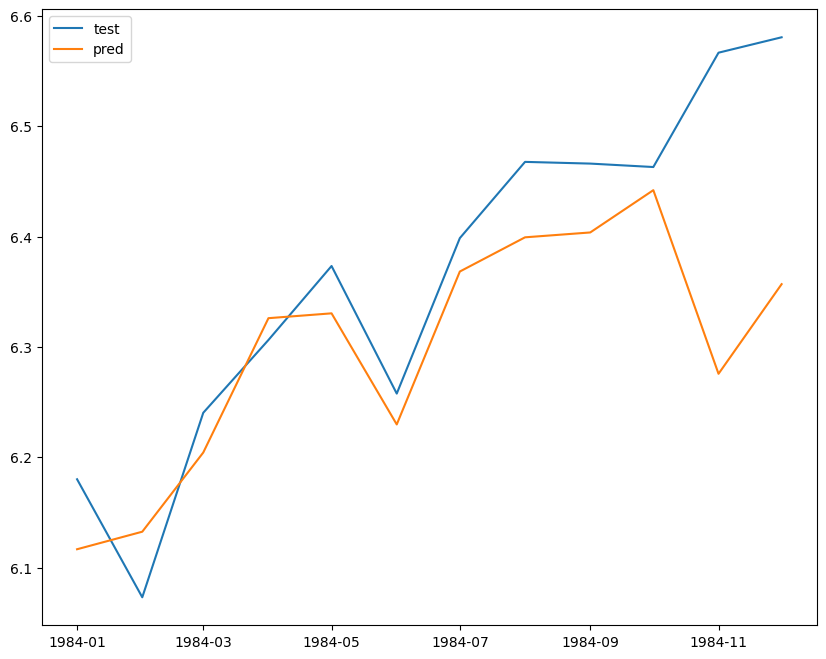

In [43]:
pred = res.forecast(len(test), exog=test.loc[:, ["PetrolPrice", "law"]])

plt.figure(figsize=(10, 8))
# plt.plot(train["timestamp"], train["log_front"], label="train")
plt.plot(test["timestamp"], test["log_front"], label="test")
plt.plot(test["timestamp"], pred.values, label="pred")
plt.legend()
plt.show()

In [42]:
pred = res.forecast(len(test), exog=test.loc[:, ["PetrolPrice", "law"]])
# 信頼区間
# pred_ci = pred.conf_int(alpha=0.05)
# pred_mean = pred.predicted_mean

# plt.plot(range(len(pred_mean)), pred_mean)
# plt.fill_between(range(len(pred_mean)), pred_ci.iloc[:, 0], pred_ci.iloc[:, 1])
# plt.show()

In [24]:
pred

180    6.133278
181    6.075633
182    6.154446
183    6.208033
184    6.296120
185    6.246380
186    6.377945
187    6.413691
188    6.349986
189    6.371924
190    6.320537
191    6.426610
Name: predicted_mean, dtype: float64